# 02_preprocessing.ipynb

Notebook de preprocessing : redimensionnement, normalisation, split, et démonstration d'augmentation.

**Objectifs:**
- Créer les splits train/val/test (70/15/15)
- Redimensionner les images à 224x224
- Normaliser les pixels (0-1)
- Sauvegarder les fichiers préprocessés dans data/processed/
- Visualiser des exemples d'images augmentées
- Calculer les class weights pour gérer le déséquilibre

In [1]:
# Imports
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Ajouter le chemin racine au PYTHONPATH
sys.path.append('..')

from src.data_processing import (
    gather_image_paths,
    create_splits,
    get_generators,
    sample_augmented_images,
    compute_class_weights_from_split,
)

%matplotlib inline
sns.set_style('whitegrid')

RAW_ROOT = '../data/raw/Covid19-dataset'
PROCESSED_ROOT = '../data/processed'

print("✓ Imports réussis")

✓ Imports réussis


## 1. Chargement des chemins d'images

In [2]:
# Récupérer les chemins des images
paths_dict = gather_image_paths(RAW_ROOT)

total_images = sum(len(v) for v in paths_dict.values())
print(f"Nombre total d'images: {total_images}")
print(f"Nombre de classes: {len(paths_dict)}")
print(f"Classes: {list(paths_dict.keys())}")

Nombre total d'images: 317
Nombre de classes: 2
Classes: ['test', 'train']


## 2. Création des splits Train/Val/Test (70/15/15)

In [3]:
# Créer les splits et copier les fichiers dans data/processed/
print("⏳ Création des splits et copie des fichiers...")
print("⚠️ Cette opération peut prendre plusieurs minutes selon la taille du dataset")

splits = create_splits(
    paths_dict, 
    output_root=PROCESSED_ROOT, 
    train_size=0.70, 
    val_size=0.15, 
    test_size=0.15,
    random_state=42,
    copy_files=True
)

print("\n✓ Splits créés avec succès!\n")

# Afficher la distribution
for split_name in ['train', 'val', 'test']:
    total = sum(len(lst) for lst in splits[split_name].values())
    print(f"{split_name.upper():5s}: {total:5d} images ({total/total_images*100:.1f}%)")
    for cls, files in splits[split_name].items():
        print(f"  - {cls}: {len(files)} images")

⏳ Création des splits et copie des fichiers...
⚠️ Cette opération peut prendre plusieurs minutes selon la taille du dataset

✓ Splits créés avec succès!

TRAIN:   221 images (69.7%)
  - test: 46 images
  - train: 175 images
VAL  :    48 images (15.1%)
  - test: 10 images
  - train: 38 images
TEST :    48 images (15.1%)
  - test: 10 images
  - train: 38 images


## 3. Visualisation de la distribution des splits

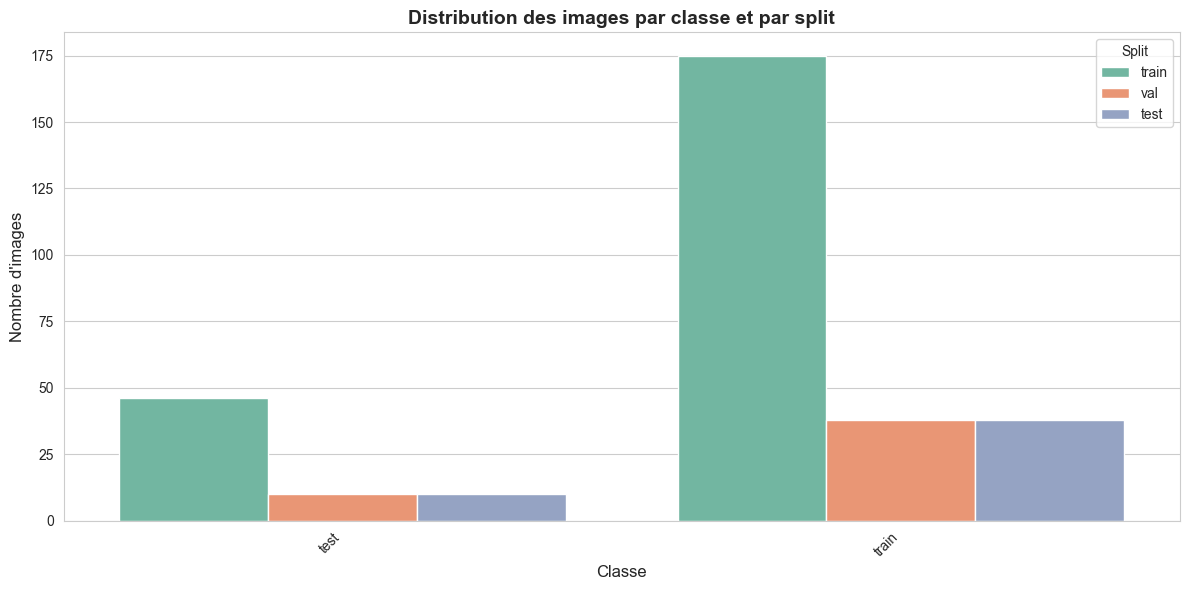

In [4]:
# Créer un DataFrame pour visualiser la distribution
split_data = []
for split_name in ['train', 'val', 'test']:
    for cls, files in splits[split_name].items():
        split_data.append({
            'split': split_name,
            'class': cls,
            'n_images': len(files)
        })

split_df = pd.DataFrame(split_data)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(data=split_df, x='class', y='n_images', hue='split', palette='Set2')
plt.title('Distribution des images par classe et par split', fontsize=14, fontweight='bold')
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split')
plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Création des ImageDataGenerators avec augmentation

In [5]:
# Préparer les generators Keras (avec augmentation pour train)
print("🔧 Création des ImageDataGenerators...\n")

try:
    train_gen, val_gen, test_gen = get_generators(
        PROCESSED_ROOT, 
        target_size=(224, 224), 
        batch_size=32, 
        augment=True,
        seed=42
    )
    
    print("✓ Generators créés avec succès!\n")
    print(f"Classes détectées: {train_gen.class_indices}")
    print(f"\nNombre de batches:")
    print(f"  - Train: {len(train_gen)} batches")
    print(f"  - Val:   {len(val_gen)} batches")
    print(f"  - Test:  {len(test_gen)} batches")
    
except Exception as e:
    print(f"❌ Erreur lors de la création des generators: {e}")
    print("Assurez-vous que TensorFlow/Keras est installé: pip install tensorflow")

🔧 Création des ImageDataGenerators...

Found 156 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 43 images belonging to 2 classes.
✓ Generators créés avec succès!

Classes détectées: {'test': 0, 'train': 1}

Nombre de batches:
  - Train: 5 batches
  - Val:   2 batches
  - Test:  2 batches


## 5. Visualisation des images augmentées

🖼️ Génération d'exemples d'images augmentées...



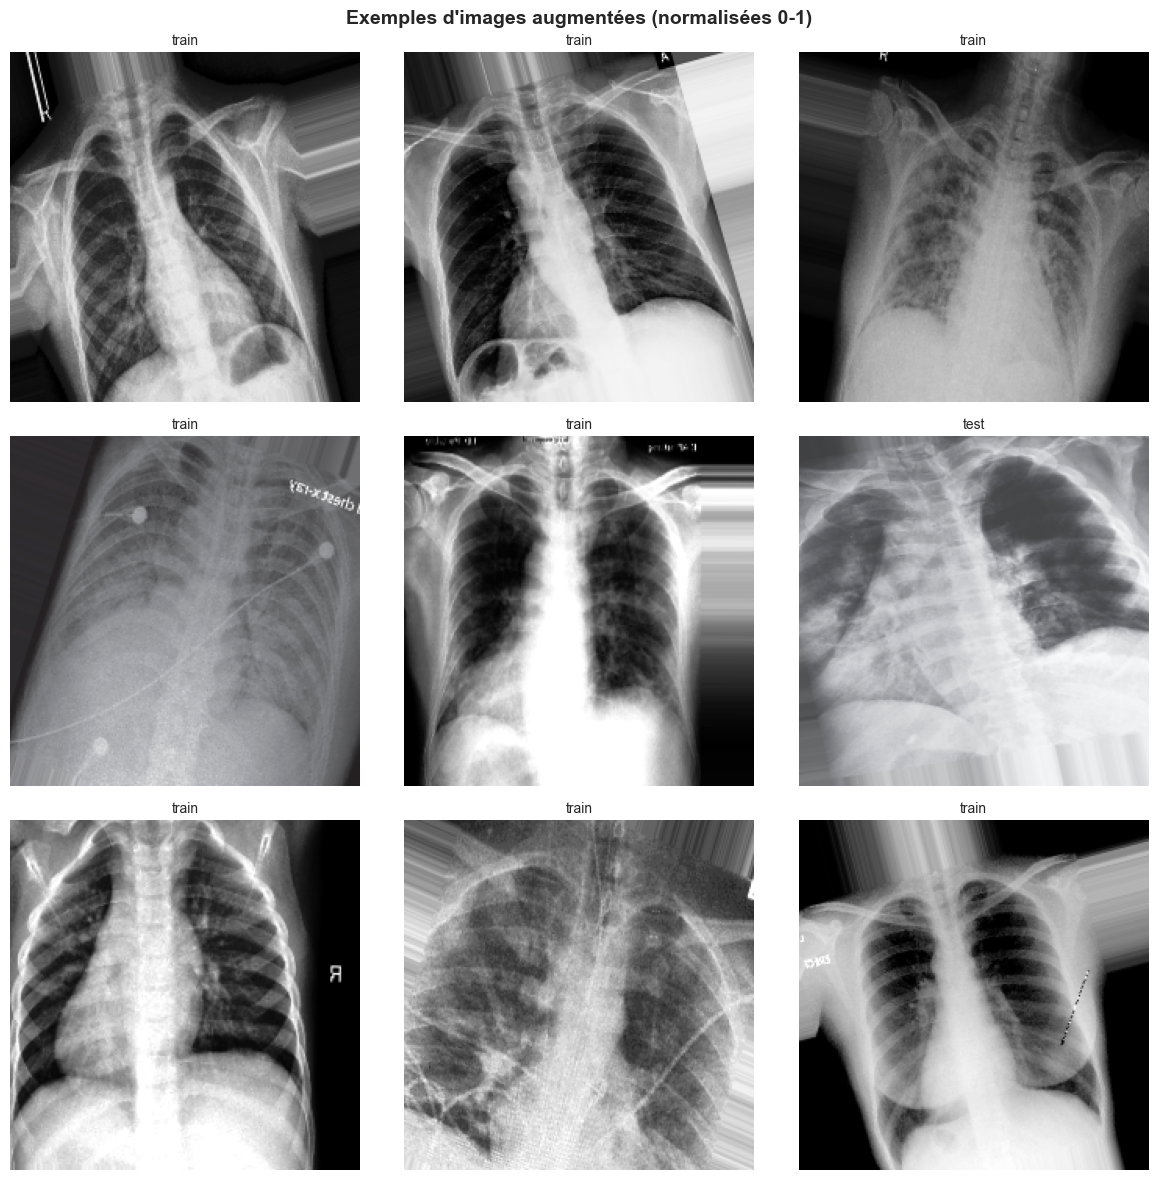

✓ Visualisation sauvegardée dans results/figures/augmented_samples.png


In [6]:
# Visualiser quelques images augmentées
print("🖼️ Génération d'exemples d'images augmentées...\n")

try:
    imgs, labels = sample_augmented_images(train_gen, n=9)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    # Inverser le mapping class_indices pour afficher les noms de classes
    idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        class_idx = np.argmax(labels[i])
        class_name = idx_to_class.get(class_idx, f"Class {class_idx}")
        ax.set_title(f"{class_name}", fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Exemples d\'images augmentées (normalisées 0-1)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../results/figures/augmented_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualisation sauvegardée dans results/figures/augmented_samples.png")
    
except Exception as e:
    print(f"❌ Impossible de visualiser les images augmentées: {e}")

## 6. Calcul des Class Weights (gestion du déséquilibre)

In [7]:
# Calculer les class weights à partir du split d'entraînement
print("⚖️ Calcul des class weights pour gérer le déséquilibre...\n")

class_weights = compute_class_weights_from_split(splits['train'])

print("Class weights calculés:")
for cls, weight in class_weights.items():
    print(f"  - {cls}: {weight:.4f}")

# Sauvegarder les class weights
import json
os.makedirs('../results/metrics', exist_ok=True)
with open('../results/metrics/class_weights.json', 'w') as f:
    json.dump(class_weights, f, indent=2)

print("\n✓ Class weights sauvegardés dans results/metrics/class_weights.json")

⚖️ Calcul des class weights pour gérer le déséquilibre...

Class weights calculés:
  - test: 2.4022
  - train: 0.6314

✓ Class weights sauvegardés dans results/metrics/class_weights.json


## 7. Comparaison: Image originale vs Image augmentée

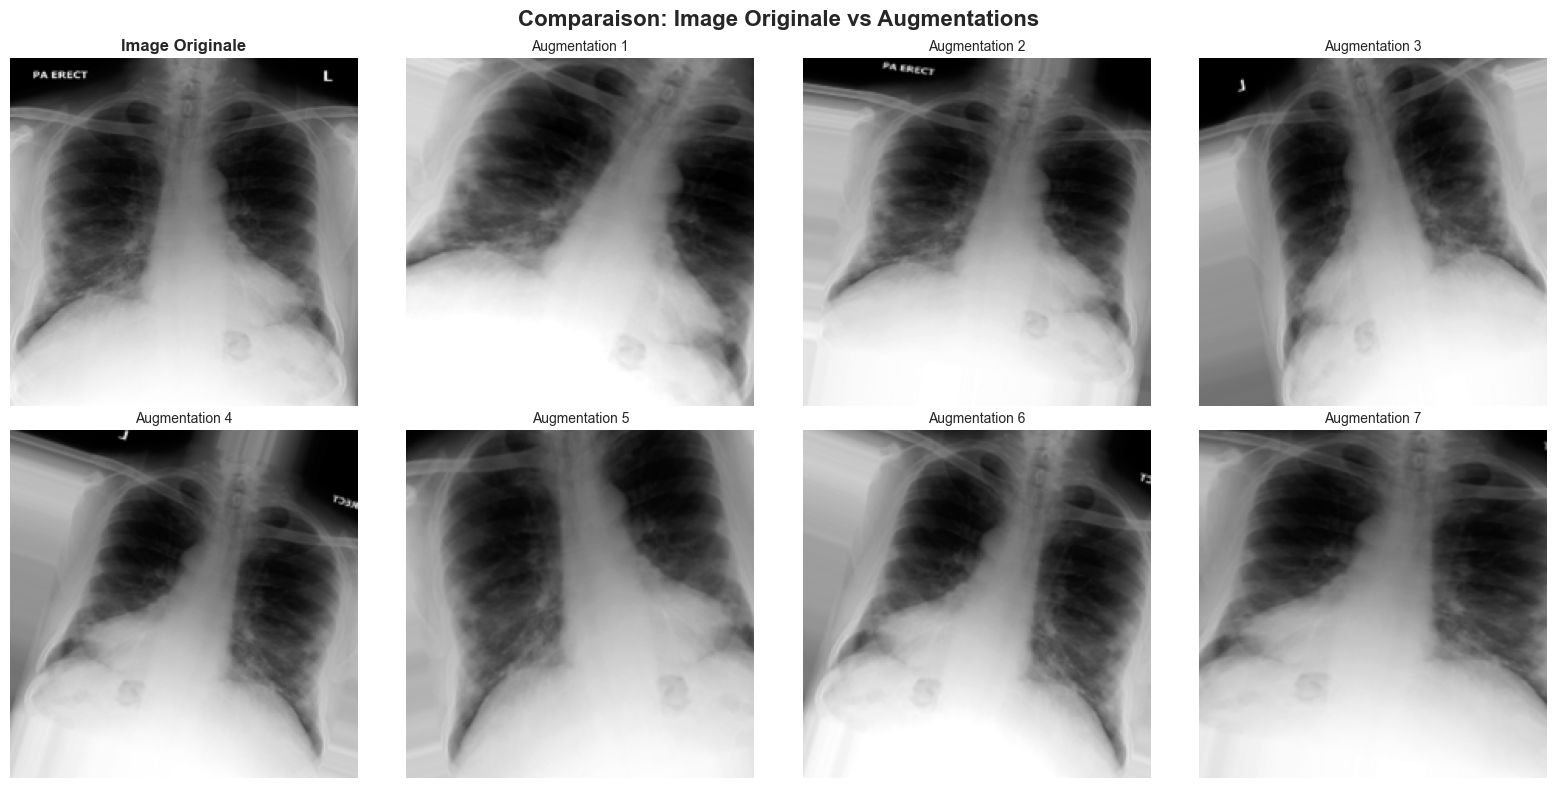

In [8]:
# Comparer image originale et images augmentées
try:
    from PIL import Image
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
    
    # Prendre une image du train set
    first_class = list(splits['train'].keys())[0]
    sample_img_path = splits['train'][first_class][0]
    
    # Charger l'image originale
    original_img = Image.open(sample_img_path).convert('RGB')
    original_img = original_img.resize((224, 224))
    
    # Créer un generator pour augmentation
    aug_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),
        fill_mode='nearest'
    )
    
    # Générer des versions augmentées
    img_array = img_to_array(original_img)
    img_array = img_array.reshape((1,) + img_array.shape)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Image originale
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Image Originale', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Générer 7 versions augmentées
    i = 1
    for batch in aug_gen.flow(img_array, batch_size=1):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(array_to_img(batch[0]))
        axes[row, col].set_title(f'Augmentation {i}', fontsize=10)
        axes[row, col].axis('off')
        i += 1
        if i >= 8:
            break
    
    plt.suptitle('Comparaison: Image Originale vs Augmentations', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../results/figures/augmentation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"❌ Erreur lors de la comparaison: {e}")

## 8. Sauvegarde des informations de preprocessing

In [9]:
# Sauvegarder les informations de preprocessing
preprocessing_info = {
    'dataset': 'Covid19-dataset',
    'total_images': total_images,
    'n_classes': len(paths_dict),
    'classes': list(paths_dict.keys()),
    'train_size': 0.70,
    'val_size': 0.15,
    'test_size': 0.15,
    'target_size': [224, 224],
    'normalization': '0-1',
    'augmentation': {
        'rotation_range': 20,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'zoom_range': 0.2,
        'horizontal_flip': True,
        'brightness_range': [0.8, 1.2]
    },
    'batch_size': 32,
    'random_state': 42
}

import json
with open('../results/metrics/preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

# Sauvegarder la distribution des splits
split_df.to_csv('../results/metrics/split_distribution.csv', index=False)

print("✓ Informations de preprocessing sauvegardées")
print("  - results/metrics/preprocessing_info.json")
print("  - results/metrics/split_distribution.csv")
print("  - results/metrics/class_weights.json")

✓ Informations de preprocessing sauvegardées
  - results/metrics/preprocessing_info.json
  - results/metrics/split_distribution.csv
  - results/metrics/class_weights.json


## 9. Résumé et Remarques

### ✅ Tâches accomplies:
- [x] Splits train/val/test créés (70/15/15)
- [x] Images copiées dans data/processed/
- [x] ImageDataGenerators configurés avec augmentation
- [x] Class weights calculés
- [x] Visualisations générées

### 📊 Configuration finale:
- **Target size**: 224x224 (compatible EfficientNet-B0)
- **Normalisation**: 0-1
- **Batch size**: 32
- **Augmentation**: Rotation (±20°), shift (±10%), zoom (±20%), flip horizontal, brightness (±20%)

### 🎯 Prochaines étapes:
1. Implémenter l'architecture EfficientNet (src/model.py)
2. Créer le script d'entraînement (src/training.py)
3. Configurer les hyperparamètres (config/config.yaml)
4. Lancer les premières expérimentations

### 💡 Points d'attention:
- Utiliser les class_weights pendant l'entraînement pour gérer le déséquilibre
- Monitorer l'overfitting (écart train/val loss)
- Ajuster le learning rate si nécessaire
- Tester différentes stratégies d'augmentation